In [130]:
import csv
import json
import os
import shutil

import librosa as rosa
import soundfile as sf

import numpy as np

from pydub import AudioSegment

import tensorflow as tf
from tensorflow.python.ops import gen_audio_ops
from IPython.display import display, Audio

import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [131]:
def plot_audio(audio):
    _, axe = plt.subplots(figsize=(8,6))
    axe.plot(audio)
    axe.set_title('Audio wave')
    axe.set_xlabel('Time')
    axe.set_ylabel('Amplitude')
    plt.show()
    display(Audio(audio, rate=16000))
    
def plot_spec(spec):
    spec = np.squeeze(spec)
    spec = np.rot90(spec, 3)
    _, axe = plt.subplots(figsize=(8, 6))
    axe.imshow(spec, aspect='auto', origin='lower', cmap='jet')
    axe.set_title('Spectrogram')
    axe.set_xlabel('Time')
    axe.set_ylabel('Frequency')
    plt.show()

In [132]:
SAMPLE_RATE = 16000
FRAME_LENGTH = 320
FRAME_STEP = 160
POOLING_SIZE = [1, 6]
VOICE_THRESHOLD = 0.25

interpreter = tf.lite.Interpreter(model_path='./app/data/model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

DETECTION_THRESHOLD = 0.5


def get_voice(audio):
    steps_per_sec = 100
    step = SAMPLE_RATE // steps_per_sec
    
    audio = normalize_audio(audio)
    abs_audio = np.abs(audio)
    
    ssum = [np.sum(abs_audio[s:s+SAMPLE_RATE]) for s in range(0, len(abs_audio), step)]
    row_sum = [np.sum(ssum[i:i+10]) for i in range(0, len(ssum))]
    first = np.argmax(row_sum) * step
    return cure_audio(audio[first:first + SAMPLE_RATE])


def begin_voice(audio):
    start, end = find_voice(audio)
    start = max(0, start - 100)
    end = min(SAMPLE_RATE, end + 100)
    return cure_audio(audio[start:end])


def find_voice(audio):
    audio_abs = np.abs(audio)
    start = np.argmax(audio_abs > VOICE_THRESHOLD)
    end = len(audio_abs) - np.argmax(audio_abs[::-1] > VOICE_THRESHOLD) - 1
    return start, end


def get_participant_dir(participant_id):
    return os.path.join("./app/data/", str(participant_id))


def add_noise(audio, noise, scale=0.1):
    start = random.randint(0, len(noise) - len(audio) - 1)
    noise = noise[start:start + len(audio)]
    audio_with_noise = audio + scale * noise
    return audio_with_noise


def find_word_in_audio(audio, sample_rate=SAMPLE_RATE, word_duration=1):
    window_size = sample_rate * word_duration
    amplitudes = [np.mean(np.abs(audio[i:i+window_size])) for i in range(0, len(audio)-window_size, window_size)]
    max_position = np.argmax(amplitudes) * window_size
    return audio[max_position:max_position + window_size]


def normalize_audio(audio):
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    return audio


def cut_audio_length(audio, length=SAMPLE_RATE):
    audio_len = len(audio)
    if audio_len < length:
        audio = np.append(audio, np.zeros(length - audio_len))
    audio = audio[:length]
    return audio


def cure_audio(audio):
    audio = cut_audio_length(audio)
    audio = normalize_audio(audio)
    return tf.cast(audio, tf.float32)


def get_spectrogram(audio):
    spec = gen_audio_ops.audio_spectrogram(tf.expand_dims(audio, -1),
                                           window_size=FRAME_LENGTH,
                                           stride=FRAME_STEP,
                                           magnitude_squared=True).numpy()

    spec = tf.expand_dims(spec, -1)
    spec = tf.nn.pool(input=spec,
                      window_shape=POOLING_SIZE,
                      strides=POOLING_SIZE,
                      pooling_type='AVG',
                      padding='SAME')
    spec = np.squeeze(spec, axis=0)
    spec = np.log10(spec + 1e-6)
    return spec


def get_background_noise_level(file_path):
    audio = AudioSegment.from_wav(file_path)
    return audio.max_dBFS

In [133]:
from pysndfx import AudioEffectsChain

def augment_audio(x):
    fx = AudioEffectsChain()
    fn = ''
    
    if np.random.random() < 0.3:
        fx = fx.highshelf()
        fn += '_hs'
        
    if np.random.random() < 0.5:
        fx = fx.reverb(np.random.randint(0, 50),
                       np.random.randint(0, 50),
                       np.random.randint(0, 100))
        fn += '_rvb'
        
    if np.random.random() < 0.8:
        fx = fx.pitch(np.random.randint(-200, 200))
        fn += '_pc'
        
    if np.random.random() < 0.3:
        fx = fx.phaser()
        fn += '_ph'
        
    if np.random.random() < 0.3:
        fx = fx.lowshelf()
        fn += '_ls'

    return fx(tf.reshape(x, -1).numpy())[:16000], fn

In [156]:
failed = 0
good = 0

DATA_PATH = './app/data/new'
TRAINING_DATA = './data/training/'
os.makedirs(TRAINING_DATA, exist_ok=True)

for user in os.listdir(DATA_PATH):
    user_dir = os.path.join(DATA_PATH, user)
    if os.path.isdir(user_dir) and user != 'new':
        with open(os.path.join(user_dir, 'participant.json'), 'r') as file:
            participant_info = json.load(file)

        noise_level = get_background_noise_level(os.path.join(user_dir, 'noise_0.wav'))
        
        data = []
        
        for file in os.listdir(user_dir):
            if file == 'noise_0.wav':
                continue
            elif file.endswith(".wav"):
                distance = file.split('_')[0]
                file_path = os.path.join(user_dir, file)
                audio, _ = rosa.load(file_path, sr=SAMPLE_RATE, mono=True)
                audio = get_voice(audio)
                
                training_file_path = os.path.join(TRAINING_DATA, 'komputer_' + user + '_' + file)
                sf.write(training_file_path, audio, SAMPLE_RATE, subtype='PCM_16')
            
#                 for i in range(10):
#                     new_audio, file_name = augment_audio(audio)
#                     new_audio = normalize_audio(new_audio)
#                     training_augumented_file_path = os.path.join(TRAINING_DATA, 'komputer_' + user + '_' + file_name + '_' + file)
#                     sf.write(training_augumented_file_path, new_audio, SAMPLE_RATE, subtype='PCM_16')
#                     plot_audio(new_audio)
                
                spec = get_spectrogram(audio)
                spec = tf.expand_dims(spec, 0)

                interpreter.set_tensor(input_details[0]['index'], spec)
                interpreter.invoke()
                output_data = np.argmax(interpreter.get_tensor(output_details[0]['index'])[0])
                detection = 1 if output_data == 0 else 0

                if detection == 0:
                    failed += 1
                    print(file_path, output_data)
#                     plot_audio(audio)
#                     plot_spec(spec)
                else:
                    good += 1

                data.append({
                    "ID": user,
                    "Płeć": participant_info["gender"],
                    "Wiek": participant_info["age"],
                    "Odległość": distance,
                    "Szum tła (dB)": noise_level,
                    "Wynik": detection
                })

        keys = data[0].keys()
        csv_filename = os.path.join(user_dir, 'results.csv')
        with open(csv_filename, 'w', newline='') as output_file:
            dict_writer = csv.DictWriter(output_file, fieldnames=keys)
            dict_writer.writeheader()
            dict_writer.writerows(data)
            
print(f'Good: {good}')
print(f'Failed: {failed}')

./app/data/new/907da96d-0d2b-41cf-9f06-5490bb7c207c/5m_1.wav 2
./app/data/new/907da96d-0d2b-41cf-9f06-5490bb7c207c/5m_0.wav 2
./app/data/new/907da96d-0d2b-41cf-9f06-5490bb7c207c/5m_2.wav 2
./app/data/new/907da96d-0d2b-41cf-9f06-5490bb7c207c/5m_3.wav 2
./app/data/new/907da96d-0d2b-41cf-9f06-5490bb7c207c/5m_4.wav 2
./app/data/new/907da96d-0d2b-41cf-9f06-5490bb7c207c/3m_3.wav 1
./app/data/new/13ac3601-00cc-4274-a5b6-0eeb064e16cc/5m_3.wav 2
./app/data/new/d90647d7-0a99-4bec-8899-4d673dff237a/5m_0.wav 2
./app/data/new/d90647d7-0a99-4bec-8899-4d673dff237a/5m_3.wav 2
./app/data/new/d90647d7-0a99-4bec-8899-4d673dff237a/50cm_0.wav 2
./app/data/new/d90647d7-0a99-4bec-8899-4d673dff237a/50cm_1.wav 2
./app/data/new/d90647d7-0a99-4bec-8899-4d673dff237a/1m_0.wav 2
Good: 208
Failed: 12


In [146]:
def convert_distance(x):
    try:
        if 'cm' in x:
            return float(x.replace('cm', '')) / 100
        elif 'm' in x:
            return float(x.replace('m', ''))
        else:
            return float(x)
    except ValueError:
        print(x)
        raise ValueError

dataframes = []

for filepath in glob.glob(DATA_PATH + '/*/results.csv'):
    df = pd.read_csv(filepath)
    dataframes.append(df)

combined_df = pd.concat(dataframes)

combined_df['Płeć'] = combined_df['Płeć'].replace({'male': 'mężczyzna', 'female': 'kobieta'})

age_dict = {'below_18': '<18', '18_30': '18-30', '31_50': '31-50', 'above_50': '50+'}
combined_df['Wiek'] = combined_df['Wiek'].replace(age_dict)
cat_type = CategoricalDtype(categories=['<18', '18-30', '31-50', '50+'], ordered=True)
combined_df['Wiek'] = combined_df['Wiek'].astype(cat_type)

dist_dict = {'50cm': 0.5, '1m': 1.0, '3m': 3.0, '5m': 5.0}
combined_df['Odległość'] = combined_df['Odległość'].replace(dist_dict)

combined_df.to_csv("combined_results.csv", index=False)

print("Pomyślnie połączono dane!")

Pomyślnie połączono dane!


In [147]:
df = pd.read_csv("combined_results.csv")

cat_type = CategoricalDtype(categories=['<18', '18-30', '31-50', '50+'], ordered=True)
df['Wiek'] = df['Wiek'].astype(cat_type)

df.head()

,ID,Płeć,Wiek,Odległość,Szum tła (dB),Wynik
0,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,5.0,-35.972244,1
1,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,5.0,-35.972244,1
2,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,5.0,-35.972244,1
3,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,5.0,-35.972244,1
4,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,0.5,-35.972244,1


In [148]:
display(df)

,ID,Płeć,Wiek,Odległość,Szum tła (dB),Wynik
0,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,5.0,-35.972244,1
1,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,5.0,-35.972244,1
2,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,5.0,-35.972244,1
3,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,5.0,-35.972244,1
4,a5c51501-421d-49e9-9514-29aaa09f9fd1,mężczyzna,50+,0.5,-35.972244,1
...,...,...,...,...,...,...
195,e2b9c89d-a72f-46e8-a7c2-b40180a92964,kobieta,18-30,1.0,-55.988932,1
196,e2b9c89d-a72f-46e8-a7c2-b40180a92964,kobieta,18-30,3.0,-55.988932,1
197,e2b9c89d-a72f-46e8-a7c2-b40180a92964,kobieta,18-30,1.0,-55.988932,1
198,e2b9c89d-a72f-46e8-a7c2-b40180a92964,kobieta,18-30,1.0,-55.988932,1


In [149]:
average_by_gender = df.groupby('Płeć')['Wynik'].mean()
display(average_by_gender.reset_index())

average_by_age = df.groupby('Wiek')['Wynik'].mean()
display(average_by_age.reset_index())

average_by_distance = df.groupby('Odległość')['Wynik'].mean()
display(average_by_distance.reset_index())

,Płeć,Wynik
0,kobieta,0.941667
1,mężczyzna,1.000000


,Wiek,Wynik
0,<18,1.000
1,18-30,1.000
2,31-50,0.975
3,50+,0.900


,Odległość,Wynik
0,0.5,1.00
1,1.0,1.00
2,3.0,0.98
3,5.0,0.88


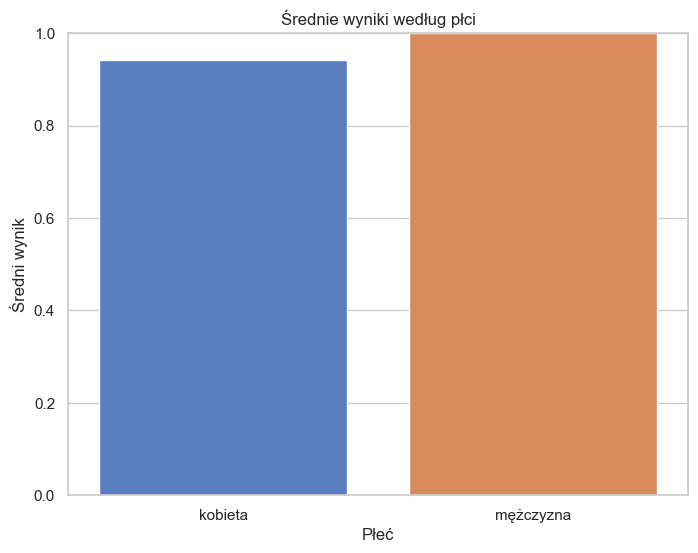

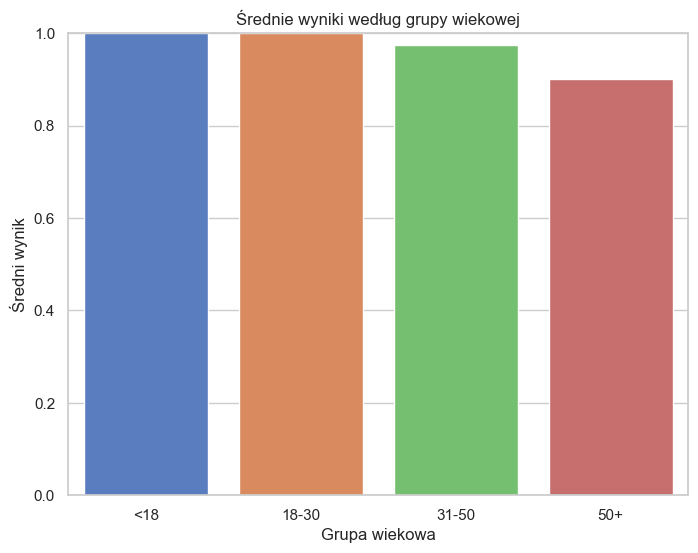

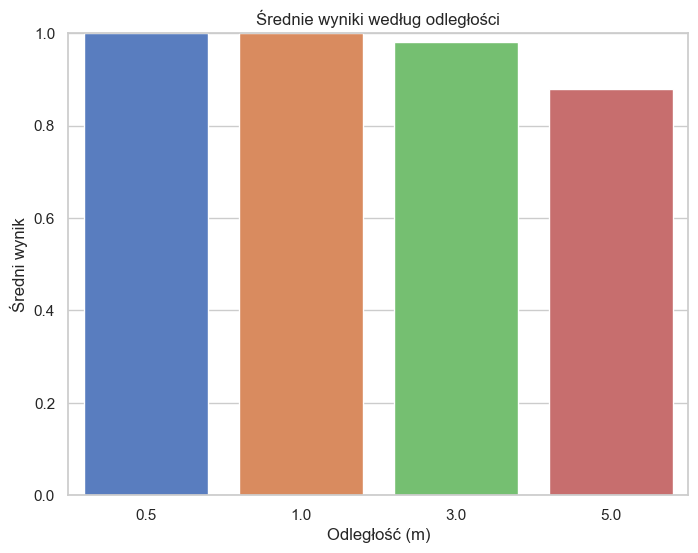

In [150]:
sns.set(style="whitegrid")

fig = plt.figure(figsize=(8, 6))
sns.barplot(x=average_by_gender.index, y=average_by_gender.values, palette="muted")
plt.title('Średnie wyniki według płci')
plt.xlabel('Płeć')
plt.ylabel('Średni wynik')
plt.ylim(0, 1)
plt.show()
fig.savefig('Średnie wyniki według płci.png')

fig = plt.figure(figsize=(8, 6))
sns.barplot(x=average_by_age.index, y=average_by_age.values, palette="muted")
plt.title('Średnie wyniki według grupy wiekowej')
plt.xlabel('Grupa wiekowa')
plt.ylabel('Średni wynik')
plt.ylim(0, 1)
plt.show()
fig.savefig('Średnie wyniki według grupy wiekowej.png')

fig = plt.figure(figsize=(8, 6))
sns.barplot(x=average_by_distance.index, y=average_by_distance.values, palette="muted")
plt.title('Średnie wyniki według odległości')
plt.xlabel('Odległość (m)')
plt.ylabel('Średni wynik')
plt.ylim(0, 1)
plt.show()
fig.savefig('Średnie wyniki według odległości.png')

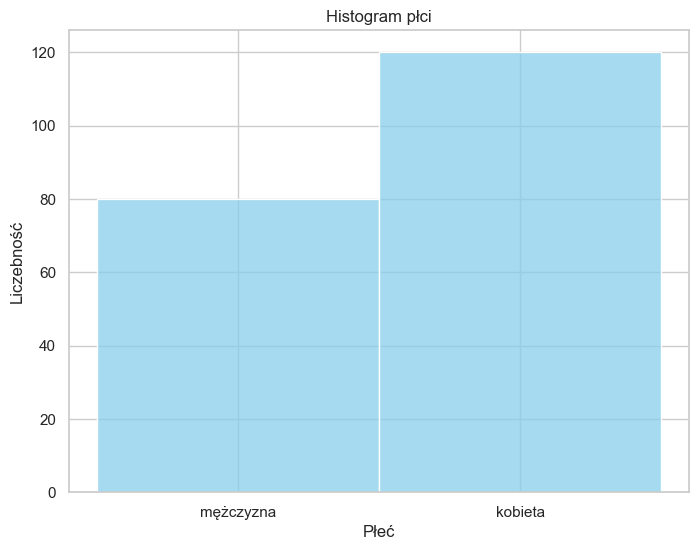

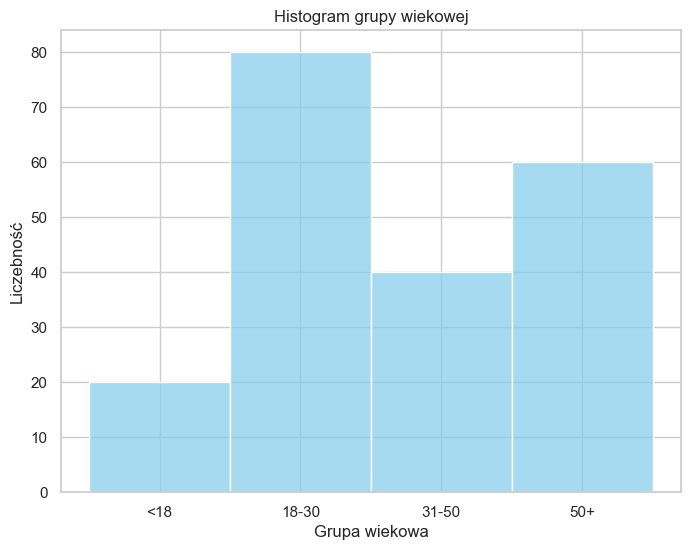

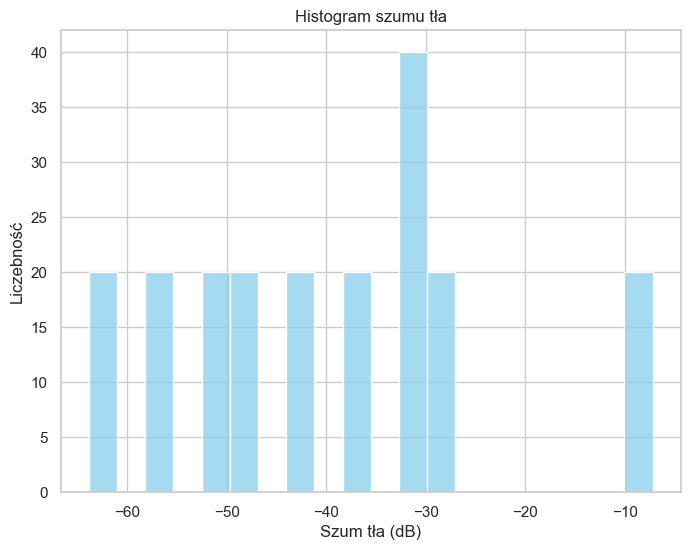

In [151]:
fig = plt.figure(figsize=(8, 6))
sns.histplot(df['Płeć'], bins=2, color='skyblue', kde=False)
plt.title('Histogram płci')
plt.xlabel('Płeć')
plt.ylabel('Liczebność')
plt.show()
fig.savefig('Histogram płci.png')

fig = plt.figure(figsize=(8, 6))
sns.histplot(df['Wiek'], bins=4, color='skyblue', kde=False)
plt.title('Histogram grupy wiekowej')
plt.xlabel('Grupa wiekowa')
plt.ylabel('Liczebność')
plt.show()
fig.savefig('Histogram grupy wiekowej.png')

fig = plt.figure(figsize=(8, 6))
sns.histplot(df['Szum tła (dB)'], bins=20, color='skyblue', kde=False)
plt.title('Histogram szumu tła')
plt.xlabel('Szum tła (dB)')
plt.ylabel('Liczebność')
plt.show()
fig.savefig('Histogram szumu tła.png')


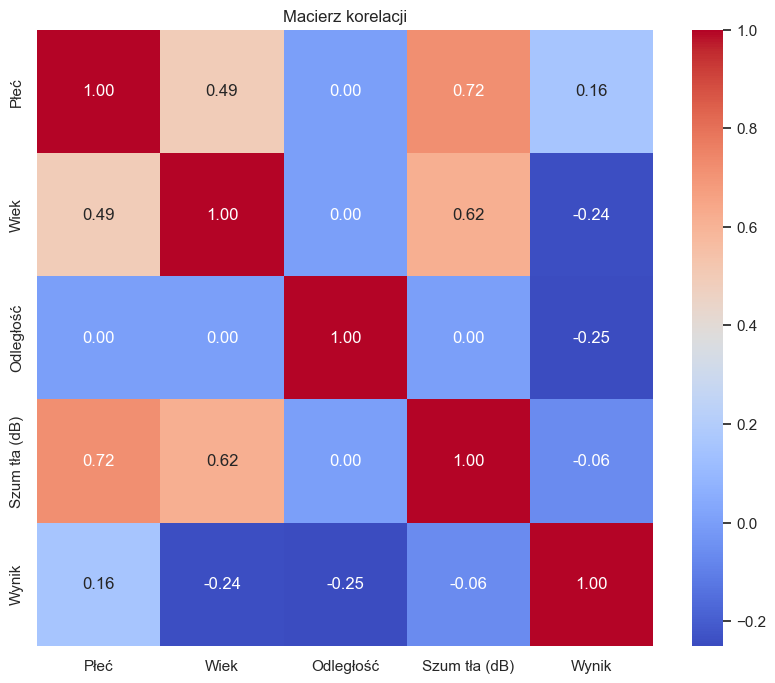

In [152]:
df_encoded = df.copy()
df_encoded['Płeć'] = np.where(df_encoded['Płeć'] == 'mężczyzna', 1, 0)
df_encoded['Wiek'] = df_encoded['Wiek'].map({'<18': 1, '18-30': 2, '30-50': 3, '50+': 4})

corr_matrix = df_encoded[['Płeć', 'Wiek', 'Odległość', 'Szum tła (dB)', 'Wynik']].corr()

fig = plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Macierz korelacji')
plt.show()
fig.savefig('Macierz korelacji.png')

In [153]:
pivot_table = df.pivot_table(values='Wynik', index=['Płeć', 'Wiek'], columns='Odległość', aggfunc='mean')
pivot_table = pivot_table.round(2)
display(pivot_table)

Odległość        0.5  1.0  3.0  5.0
Płeć      Wiek                     
kobieta   <18    1.0  1.0  1.0  1.0
          18-30  1.0  1.0  1.0  1.0
          31-50  1.0  1.0  1.0  0.8
          50+    1.0  1.0  0.8  0.0
mężczyzna 18-30  1.0  1.0  1.0  1.0
          31-50  1.0  1.0  1.0  1.0
          50+    1.0  1.0  1.0  1.0

In [154]:
pivot_table = pivot_table.fillna(0)
display(pivot_table)

Odległość        0.5  1.0  3.0  5.0
Płeć      Wiek                     
kobieta   <18    1.0  1.0  1.0  1.0
          18-30  1.0  1.0  1.0  1.0
          31-50  1.0  1.0  1.0  0.8
          50+    1.0  1.0  0.8  0.0
mężczyzna 18-30  1.0  1.0  1.0  1.0
          31-50  1.0  1.0  1.0  1.0
          50+    1.0  1.0  1.0  1.0

In [155]:
unique_ids = df['ID'].unique()

for id in unique_ids:
    participant_data = df[df['ID'] == id]
    pivot_table = participant_data.pivot_table(values='Wynik', index='Odległość', aggfunc='mean')
    print(f"Uczestnik: {id} ({participant_data['Płeć'].iloc[0]} [{participant_data['Wiek'].iloc[0]}])")
    display(pivot_table)

Uczestnik: a5c51501-421d-49e9-9514-29aaa09f9fd1 (mężczyzna [50+])


,Wynik
Odległość,
0.5,1
1.0,1
3.0,1
5.0,1


Uczestnik: 907da96d-0d2b-41cf-9f06-5490bb7c207c (kobieta [50+])


,Wynik
Odległość,
0.5,1.0
1.0,1.0
3.0,0.8
5.0,0.0


Uczestnik: 3d029e84-c595-4271-9463-c6fc2afc8ced (mężczyzna [50+])


,Wynik
Odległość,
0.5,1
1.0,1
3.0,1
5.0,1


Uczestnik: 13ac3601-00cc-4274-a5b6-0eeb064e16cc (kobieta [31-50])


,Wynik
Odległość,
0.5,1.0
1.0,1.0
3.0,1.0
5.0,0.8


Uczestnik: f7e4e605-c0d0-48a4-a331-7c6201a5af7a (kobieta [18-30])


,Wynik
Odległość,
0.5,1
1.0,1
3.0,1
5.0,1


Uczestnik: 6b81b662-0921-43dd-adf4-996d7a940c7e (kobieta [<18])


,Wynik
Odległość,
0.5,1
1.0,1
3.0,1
5.0,1


Uczestnik: b1982009-a9c4-418c-b55f-b91cb851b3d7 (mężczyzna [18-30])


,Wynik
Odległość,
0.5,1
1.0,1
3.0,1
5.0,1


Uczestnik: 41ca498c-6d4b-47e9-91ab-eed194a9e632 (kobieta [18-30])


,Wynik
Odległość,
0.5,1
1.0,1
3.0,1
5.0,1


Uczestnik: b4a5a8af-1921-454c-a5f3-fbcfbe218f7e (mężczyzna [31-50])


,Wynik
Odległość,
0.5,1
1.0,1
3.0,1
5.0,1


Uczestnik: e2b9c89d-a72f-46e8-a7c2-b40180a92964 (kobieta [18-30])


,Wynik
Odległość,
0.5,1
1.0,1
3.0,1
5.0,1
